# Converting Networkx Graph to Plotly Graph

In this notebook, we try to convert the networkx graphs created in the [repo_analysis](repo_analysis.ipynb) notebook to plotly graphs for better visualization and interactivity.

## Tables of Contents
- [Introduction](#introduction)
- [Database Connection](#connect-to-the-augur-database)
- [Loading the URLs of Repositories](#load-the-urls-of-ai-repositories)
- [Retrieve the Data](#retrieve-the-data)
  - [Retreve repository ID and names](#retrieve-the-repository-ids-and-the-repository-names)
  - [Rerieve Pull Request Contributors](#retrieve-pull-request-contributors)
- [Creating Networkx Graph](#creating-networkx-graph)
- [Converting Networkx to Plotly Graph](#converting-the-above-graph-to-plotly)

## Introduction

This script performs network analysis and visualization using NetworkX and Plotly. It constructs a network graph based on shared contributors between repositories, adds node and edge attributes, and creates an interactive visualization with hover information.


Import all the necessary libraries.

In [1]:
# Importing the pandas library for data manipulation and analysis
import pandas as pd

# Importing the collections module for specialized container datatypes
import collections

# Importing the SQLAlchemy library for SQL database toolkit and Object-Relational Mapping (ORM)
import sqlalchemy as salc

# Importing the json module to work with JSON data
import json

# Importing the NetworkX library for creating and analyzing complex networks
import networkx as nx

# Importing the pyplot module from matplotlib for plotting and visualization
import matplotlib.pyplot as plt

# Importing the patches module from matplotlib for creating graphical patches
import matplotlib.patches as mpatches

# Importing specific functions from SQLAlchemy
from sqlalchemy import create_engine, text

# Importing the interp1d function from scipy.interpolate for one-dimensional interpolation
from scipy.interpolate import interp1d

# Importing the numpy library for numerical operations, such as array manipulations and mathematical functions
import numpy as np

# Importing the plotly.graph_objects module for creating interactive plots and graphs
import plotly.graph_objects as go


## Connect to the Augur database

In [2]:
# Opening the JSON file containing database credentials and loading it into a dictionary
with open("data/il_ai_creds.json") as config_file:
    config = json.load(config_file)
    
# Creating a PostgreSQL database connection string using the credentials from the JSON file
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(
    config['user'],        # Username
    config['password'],    # Password
    config['host'],        # Hostname
    config['port'],        # Port number
    config['database']     # Database name
)

# Assigning the connection string to a variable
connection_string = database_connection_string

# Creating a SQLAlchemy engine using the connection string
engine = create_engine(connection_string)

## Load the URLs of AI repositories

- There are different verticals like math, nlp, gen_ai, personal_assistants, llm etc
- In this notebook, we are performing our analysis on math repositories as graphical interpretation will be too messy if we try to plot all at once
- If you want to perform the same analysis on other verticals, just replace math with your choice in `data.get('math')`

In [3]:
# Opening the JSON file containing AI repository data and loading it into a dictionary
f = open('ai_repos.json')
data = json.load(f)

# Closing the file after loading the data
f.close()  

# print the collected repositories
from pprint import pprint
pprint(data)


{'gen_ai': ['https://github.com/lucidrains/imagen-pytorch',
            'https://github.com/langchain-ai/langchain',
            'https://github.com/run-llama/llama_index',
            'https://github.com/microsoft/lora',
            'https://github.com/nvidia/nemo',
            'https://github.com/huggingface/peft',
            'https://github.com/microsoft/semantic-kernel',
            'https://github.com/chroma-core/chroma',
            'https://github.com/milvus-io/milvus',
            'https://github.com/qdrant/qdrant',
            'https://github.com/bigscience-workshop/promptsource',
            'https://github.com/automatic1111/stable-diffusion-webui'],
 'llm': ['https://github.com/huggingface/transformers',
         'https://github.com/huggingface/datasets',
         'https://github.com/huggingface/trl',
         'https://github.com/microsoft/deepspeed',
         'https://github.com/timdettmers/bitsandbytes',
         'https://github.com/mistralai/mistral-common',
         'ht

In [4]:
# Initializing an empty list to store repository git URLs
repo_git_set = []

# Extracting the list of repositories under the 'math' category from the loaded JSON data
repo_git_set = data.get('math')

Uncomment below cell if all the catergories needs to be analyzed at once.

In [5]:
# for key in data.keys():
#     repo_git_set.extend(data.get(key))

## Retrieve the Data

### Retrieve the repository IDs and the repository names

Let's retrieve the repository IDs and names from the augur database.

In [6]:
# Initializing empty lists to store repository IDs and names
repo_set = []
repo_name_set = []

# Iterating through the list of repository git URLs
for repo_git in repo_git_set:
    # Creating a SQL query to fetch repository ID and name for each git URL
    repo_query = text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        b.repo_id,
                        b.repo_name
                    FROM
                        repo_groups a,
                        repo b
                    WHERE
                        a.repo_group_id = b.repo_group_id AND
                        b.repo_git = '{repo_git}'
            """)

    # Using the connection to execute the query
    with engine.connect() as connection:
        t = connection.execute(repo_query)  # Executing the query
        results = t.mappings().all()  # Fetching all the results
        
        # Checking if results are found and extracting repo_id and repo_name
        if results:
            repo_id = results[0]['repo_id']
            repo_name = results[0]['repo_name']
        else:
            repo_id = None
            repo_name = None
        
        # Appending the fetched repository ID and name to the respective lists
        repo_set.append(repo_id)
        repo_name_set.append(repo_name)

# Printing the lists of repository IDs and names
print(repo_set)
print(repo_name_set)

[25495, 25498, 25497, 25501, 25500, 25504, 25503, 25496, 25502, 25499]
['numpy', 'tensorflow', 'networkx', 'pytorch', 'keras-io', 'tinygrad', 'pandas', 'polaris', 'arrow', 'mlx']


### Retrieve Pull Request Contributors

Any type of contribution can be taken to retrieve data to create networkx and plotly graphs. Here, we are fetching all the Pull Request contributors for various repositories.

In [7]:
# Initializing an empty DataFrame to store pull request contributions
pr_contrib = pd.DataFrame()

# Iterating through the list of repository IDs
for repo_id in repo_set:
    # Skipping if repo_id is None
    if not repo_id:
        continue
    
    # Creating a SQL query to fetch pull request contributions for each repository
    repo_query = salc.sql.text(f"""
                    SET SCHEMA 'augur_data';
                    SELECT 
                        r.repo_id,
                        r.repo_name,
                        r.repo_git,
                        pr.pr_augur_contributor_id,
                        pr.pull_request_id
                    FROM
                        repo r, pull_requests pr
                    WHERE
                        pr.repo_id = '{repo_id}' AND
                        pr.repo_id = r.repo_id
                """)
    
    # Executing the query and reading the results into a DataFrame
    df_current_repo = pd.read_sql(repo_query, con=engine)
    
    # Concatenating the current repository's data with the main DataFrame
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

# Resetting the index of the DataFrame
pr_contrib = pr_contrib.reset_index()

# Dropping the old index column
pr_contrib.drop("index", axis=1, inplace=True)

# Renaming the columns of the DataFrame
pr_contrib.columns = ['repo_id', 'repo_name', 'repo_git', 'cntrb_id', 'pull_request_id']

# Displaying the DataFrame
display(pr_contrib)

# Displaying the data types of the DataFrame columns
pr_contrib.dtypes

,repo_id,repo_name,repo_git,cntrb_id,pull_request_id
0,25495,numpy,https://github.com/numpy/numpy,0100167f-9f00-0000-0000-000000000000,269773
1,25495,numpy,https://github.com/numpy/numpy,0100012d-d800-0000-0000-000000000000,269774
2,25495,numpy,https://github.com/numpy/numpy,01000088-e600-0000-0000-000000000000,269775
3,25495,numpy,https://github.com/numpy/numpy,010000b4-3700-0000-0000-000000000000,269777
4,25495,numpy,https://github.com/numpy/numpy,010000f2-1900-0000-0000-000000000000,269778
...,...,...,...,...,...
203204,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41537
203205,25499,mlx,https://github.com/ml-explore/mlx,010012f3-bb00-0000-0000-000000000000,41538
203206,25499,mlx,https://github.com/ml-explore/mlx,0103993a-2500-0000-0000-000000000000,41539
203207,25499,mlx,https://github.com/ml-explore/mlx,0100178a-9500-0000-0000-000000000000,41540


repo_id             int64
repo_name          object
repo_git           object
cntrb_id           object
pull_request_id     int64
dtype: object

In [8]:
# Group by 'repo_name' and 'cntrb_id', count occurrences, and reshape with 'repo_name' as columns
df_pr = pr_contrib.groupby(['repo_name', 'cntrb_id']).size().unstack(fill_value=0)

In the dataframe, each row represents a repository name and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_pr`, each contribution represents a PR contribution. A value 0 means that a particular contributor has made no PR contributions to the repository, and a number `x` means that the contributor has made `x` number of PR contributions to the repository.

In [9]:
# Display the PR dataframe
df_pr.head()

cntrb_id,01000000-5000-0000-0000-000000000000,01000002-3300-0000-0000-000000000000,01000002-5600-0000-0000-000000000000,01000002-8100-0000-0000-000000000000,01000004-6200-0000-0000-000000000000,01000004-c700-0000-0000-000000000000,01000004-ca00-0000-0000-000000000000,01000004-e100-0000-0000-000000000000,01000005-2200-0000-0000-000000000000,01000006-8000-0000-0000-000000000000,...,010a5f5c-ab00-0000-0000-000000000000,010a65e1-0a00-0000-0000-000000000000,010a6612-2d00-0000-0000-000000000000,010a7247-3d00-0000-0000-000000000000,010a7473-6500-0000-0000-000000000000,010a747f-ae00-0000-0000-000000000000,010a75bf-8800-0000-0000-000000000000,010a76ec-fd00-0000-0000-000000000000,010a79ef-4700-0000-0000-000000000000,010a824a-5f00-0000-0000-000000000000
repo_name,,,,,,,,,,,,,,,,,,,,,
arrow,0,52,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
keras-io,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mlx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
networkx,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
numpy,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,1,1,0,0,0,0


When we use groupby and unstack, the resulting DataFrame has a multi-level index, where the original index values become part of the columns. Resetting the index flattens the DataFrame, making it easier to work with in subsequent operations.

In [10]:
df_pr = df_pr.reset_index()

Apply melt function to reshape the DataFrame. In wide format, we have multiple columns representing different contributors. Melting the DataFrame converts these columns into a single column, `cntrb_id` , making the DataFrame longer and narrower.

In [11]:
# Melt df_pr from wide to long format, using 'repo_name' as the identifier variable
df_melted_pr = df_pr.melt(
    ['repo_name'],        # Columns to keep as identifier variables
    var_name='cntrb_id',  # Name for the variable column
    value_name='number'   # Name for the values column
)

In [12]:
# Filter df_melted_commit to keep only rows where the 'number' column is not equal to 0
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]

The resultant dataframe after filtering and keeping only the rows where the value in the third column i.e., number of contributions count (`number`) is not equal to 0

In [13]:
df_melted_pr.head()

,repo_name,cntrb_id,number
8,tensorflow,01000000-5000-0000-0000-000000000000,3
10,arrow,01000002-3300-0000-0000-000000000000,52
28,tensorflow,01000002-5600-0000-0000-000000000000,3
35,pandas,01000002-8100-0000-0000-000000000000,1
48,tensorflow,01000004-6200-0000-0000-000000000000,1


Let's construct a dictionary called `contributorGraph` from the DataFrame `df_melted_pr`. The purpose of this dictionary is to map each contributor (cntrb_id) to a list of repositories (repo_name) they have contributed to.

In [14]:
# Initialize an empty dictionary to store the graph
contributorGraph = {}

# Iterate over each row in df_melted_pr
for i, row in df_melted_pr.iterrows():
    # If the 'cntrb_id' is not already a key in the dictionary, add it with an empty list
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    
    # Append the repository name to the list for this 'cntrb_id'
    contributorGraph[row['cntrb_id']].append(row['repo_name'])

Let's calculates the number of common contributors for each pair of repositories based on the data in the `contributorGraph` dictionary.

In [15]:
# Initialize a defaultdict to store the count of common contributors for each pair of repositories
commonRepoContributorsCount = collections.defaultdict(int)

# Iterate over each contributor in the contributorGraph
for key in contributorGraph:
    # Skip contributors with less than 2 repositories in their list
    if len(contributorGraph[key]) <= 1:
        continue
    
    # Iterate through the list of repositories for the current contributor
    for repo1 in range(len(contributorGraph[key]) - 1):
        for repo2 in range(repo1 + 1, len(contributorGraph[key])):
            # Update the count of common contributors for the pair of repositories
            commonRepoContributorsCount[
                (contributorGraph[key][repo1], contributorGraph[key][repo2])
            ] += 1

# Print the items of the commonRepoContributorsCount dictionary
print(commonRepoContributorsCount.items())

dict_items([(('pytorch', 'tensorflow'), 354), (('arrow', 'pandas'), 118), (('pandas', 'pytorch'), 130), (('pandas', 'tinygrad'), 7), (('pytorch', 'tinygrad'), 25), (('tensorflow', 'tinygrad'), 19), (('arrow', 'pytorch'), 41), (('numpy', 'pandas'), 337), (('numpy', 'tensorflow'), 106), (('pandas', 'tensorflow'), 119), (('arrow', 'keras-io'), 4), (('arrow', 'networkx'), 17), (('arrow', 'numpy'), 52), (('arrow', 'polaris'), 2), (('arrow', 'tensorflow'), 42), (('arrow', 'tinygrad'), 4), (('keras-io', 'networkx'), 3), (('keras-io', 'numpy'), 8), (('keras-io', 'pandas'), 17), (('keras-io', 'polaris'), 2), (('keras-io', 'pytorch'), 22), (('keras-io', 'tensorflow'), 71), (('keras-io', 'tinygrad'), 2), (('networkx', 'numpy'), 66), (('networkx', 'pandas'), 85), (('networkx', 'polaris'), 2), (('networkx', 'pytorch'), 26), (('networkx', 'tensorflow'), 29), (('networkx', 'tinygrad'), 4), (('numpy', 'polaris'), 2), (('numpy', 'pytorch'), 153), (('numpy', 'tinygrad'), 7), (('pandas', 'polaris'), 2), 

Let's create a list of tuples called `repo_common_contributors` that contains the pairs of repository names and the count of common contributors between them.

In [16]:
repo_common_contributors = []

# Iterate over each key-value pair in commonRepoContributionsByContributor
for key in commonRepoContributorsCount:
    # Convert the key (a tuple of repository names) to strings and append the corresponding value
    repo_common_contributors.append(
        tuple(str(k) for k in list(key)) + (commonRepoContributorsCount[key],)
    )
print(repo_common_contributors)

[('pytorch', 'tensorflow', 354), ('arrow', 'pandas', 118), ('pandas', 'pytorch', 130), ('pandas', 'tinygrad', 7), ('pytorch', 'tinygrad', 25), ('tensorflow', 'tinygrad', 19), ('arrow', 'pytorch', 41), ('numpy', 'pandas', 337), ('numpy', 'tensorflow', 106), ('pandas', 'tensorflow', 119), ('arrow', 'keras-io', 4), ('arrow', 'networkx', 17), ('arrow', 'numpy', 52), ('arrow', 'polaris', 2), ('arrow', 'tensorflow', 42), ('arrow', 'tinygrad', 4), ('keras-io', 'networkx', 3), ('keras-io', 'numpy', 8), ('keras-io', 'pandas', 17), ('keras-io', 'polaris', 2), ('keras-io', 'pytorch', 22), ('keras-io', 'tensorflow', 71), ('keras-io', 'tinygrad', 2), ('networkx', 'numpy', 66), ('networkx', 'pandas', 85), ('networkx', 'polaris', 2), ('networkx', 'pytorch', 26), ('networkx', 'tensorflow', 29), ('networkx', 'tinygrad', 4), ('numpy', 'polaris', 2), ('numpy', 'pytorch', 153), ('numpy', 'tinygrad', 7), ('pandas', 'polaris', 2), ('polaris', 'pytorch', 2), ('polaris', 'tensorflow', 2), ('polaris', 'tinygra

## Creating Networkx Graph

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [17]:
# Create an empty undirected graph
g = nx.Graph()

# Add edges with weights to the graph from the 'repo_common_contributors' list
# Each item in 'repo_common_contributors' should be a tuple in the format (node1, node2, weight)
g.add_weighted_edges_from(repo_common_contributors)

The graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If two nodes are close to each other, the two projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. 

### Summary of the graph

This graph represents a network visualization of open-source repositories, where nodes represent individual repositories and edges represent the number of shared contributors between those repositories.

**Node Size**: The size of each node is proportional to the number of connections (degree) it has, indicating its centrality in the network.

**Edge Width**: The width of each edge is proportional to the number of shared contributors between the connected repositories, illustrating the strength of the connection.

**Numbers on Edges**: These numbers indicate the exact count of shared contributors between the respective repositories.

The visualization aims to highlight the interconnectedness among various open-source repositories and identify key repositories that serve as hubs of collaboration. This analysis is useful for understanding the dynamics of open-source contributions and identifying influential repositories.

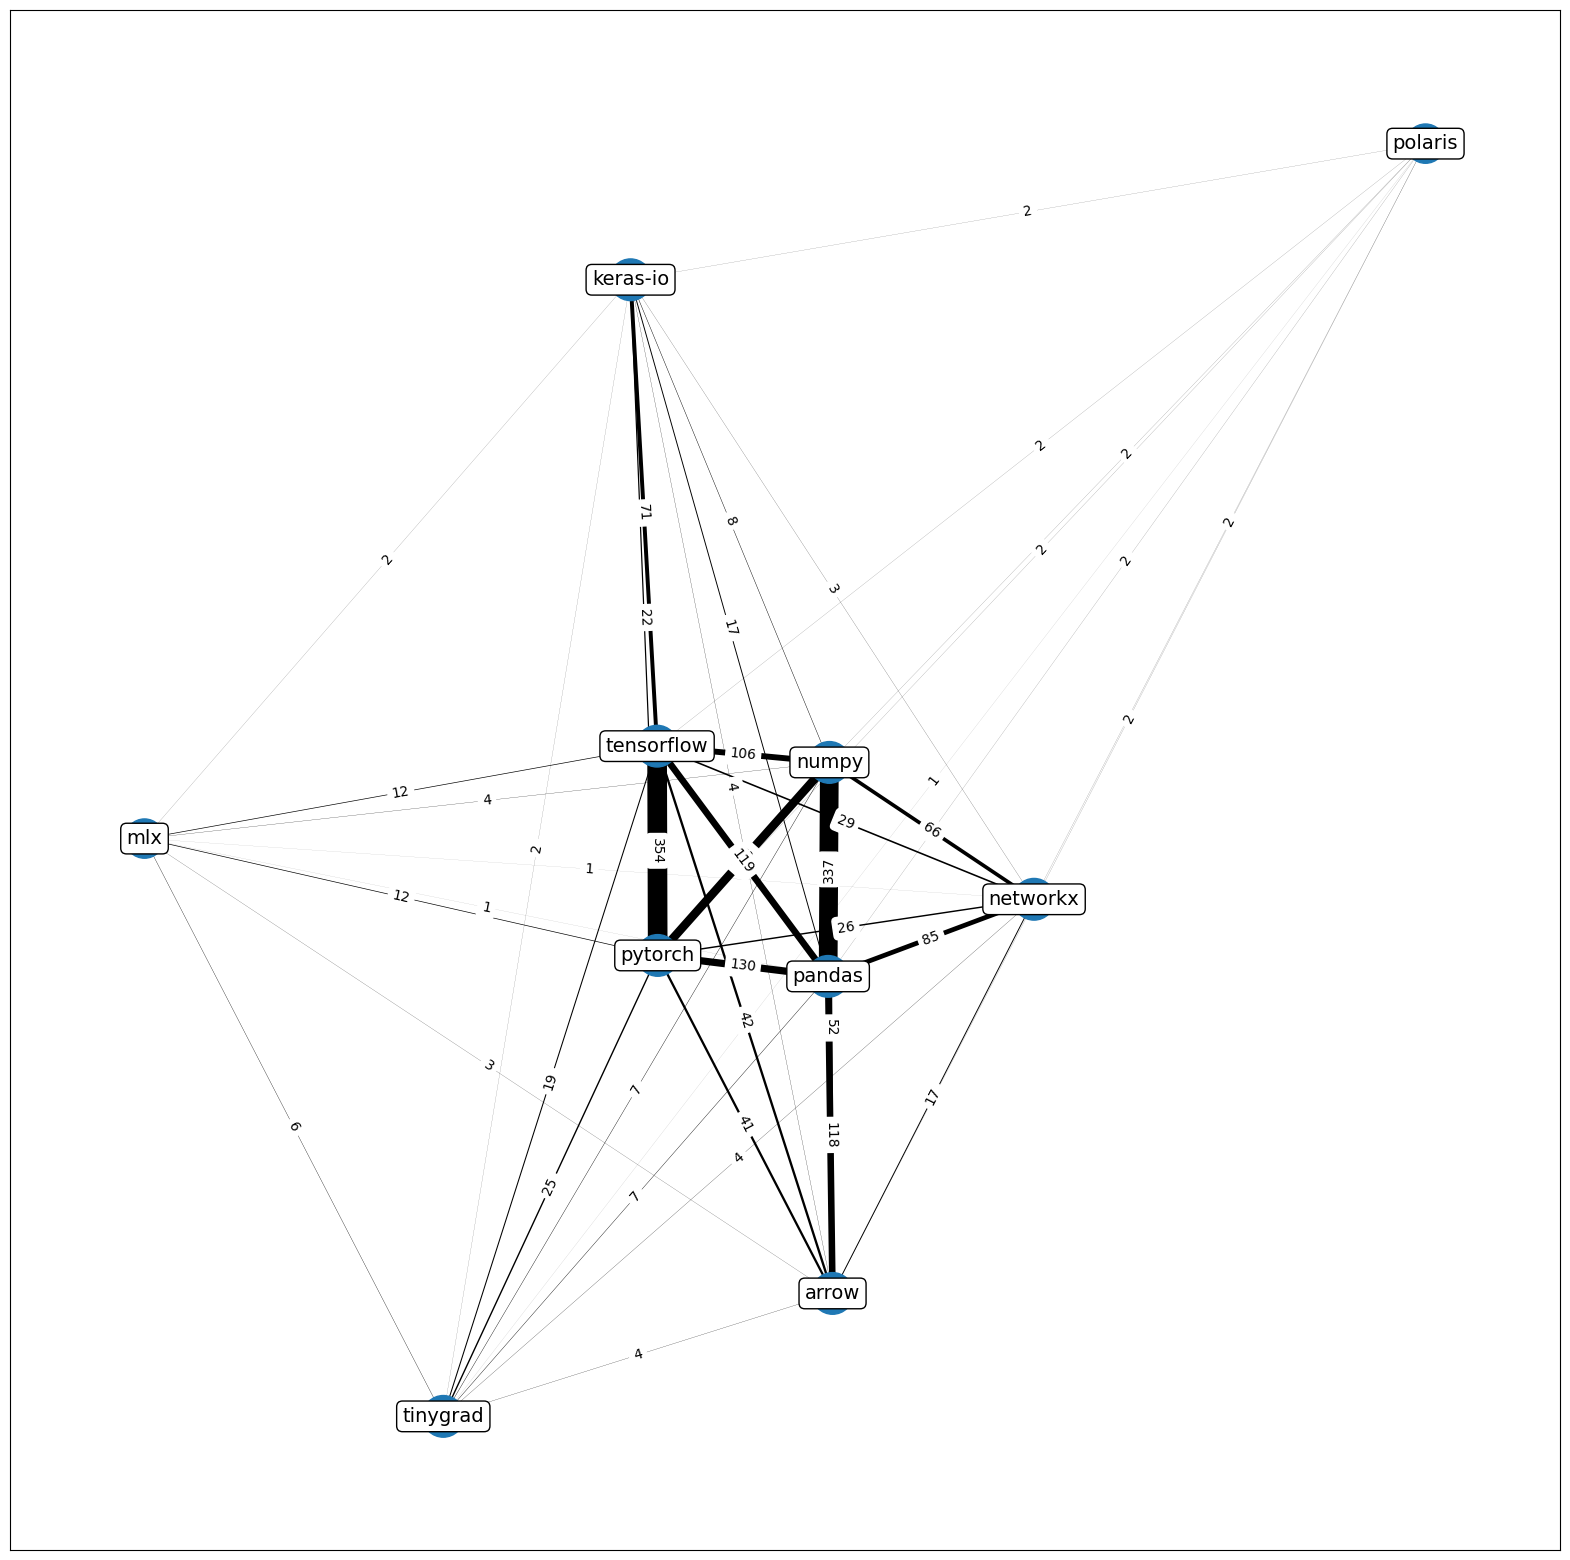

In [24]:
# Get positions for all nodes
pos = nx.spring_layout(g)

# Draw the nodes with sizes based on their degree
node_sizes = [nx.degree(g, n) * 100 for n in g.nodes()]

# Draw the edges with widths based on their weight
edge_widths = [g[u][v]['weight'] / 25 for u, v in g.edges()]

# Create a plot with the specified size
fig, ax = plt.subplots(figsize=(20, 20))

# Draw the nodes and edges with the specified attributes
nx.draw_networkx_nodes(g, pos, node_size=node_sizes, ax=ax)
nx.draw_networkx_edges(g, pos, width=edge_widths, ax=ax)

# Draw the labels with a background box for readability
nx.draw_networkx_labels(g, pos, font_size=14, ax=ax, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# Draw edge labels with the number of contributors
edge_labels = {(u, v): g[u][v]['weight'] for u, v in g.edges()}
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=10, ax=ax)

# Display the plot
plt.show()

## Converting the above graph to plotly

### Graph Visualization

This graph visualization provides insights into the relationships between repositories based on shared contributors. The following points outline the key features and attributes of the graph:

1. **Graph Creation**:
   - **Type**: An undirected graph is created using NetworkX.
   - **Edges**: Weighted edges are added to represent the number of shared contributors between repositories.

2. **Node Positioning**:
   - **Algorithm**: Nodes are positioned using the spring layout, which aims to balance edge lengths and reduce edge crossings.

3. **Node Size**:
   - **Metric**: Node sizes are proportional to their degree, indicating the number of connections.

4. **Edge Visualization**:
   - **Smoothness**: Edges are drawn with interpolated points for a smoother appearance.
   - **Attributes**: Edge widths represent the number of shared contributors, and edges are colored blue. Hovering over an edge reveals its weight.

5. **Node Visualization**:
   - **Markers**: Nodes are displayed as markers, with sizes based on their degree and a black color scheme.
   - **Hover Information**: Labels appear when hovering over nodes, providing repository names.

6. **Annotations and Layout**:
   - **Labels**: Node labels are annotated directly on the plot with a styled background for readability.
   - **Dimensions**: The figure is sized and margined for clarity, with grid lines and tick labels disabled.

7. **Interactive Features**:
   - **User Interaction**: The Plotly figure supports interactive exploration, allowing users to hover over nodes and edges for detailed information.

This visualization helps in understanding the network structure and the strength of connections between repositories based on their shared contributors.


In [23]:
# Create a graph and add weighted edges
g = nx.Graph()
g.add_weighted_edges_from(repo_common_contributors)

# Get positions for all nodes using the spring layout algorithm
pos = nx.spring_layout(g)

# Calculate node sizes based on their degree
node_sizes = [nx.degree(g, n) for n in g.nodes()]

# Extract the x and y coordinates of the nodes
x_nodes = [pos[node][0] for node in g.nodes()]
y_nodes = [pos[node][1] for node in g.nodes()]

# Create the Plotly figure
fig = go.Figure()

# Iterate through edges to add them to the Plotly figure
for edge in g.edges(data=True):
    x0, y0 = pos[edge[0]]  # Starting coordinates of the edge
    x1, y1 = pos[edge[1]]  # Ending coordinates of the edge
    x_edges = [x0, x1]  # x-coordinates for the edge
    y_edges = [y0, y1]  # y-coordinates for the edge

    # Generate interpolated points between the nodes for smoother edges
    num_points = 500
    interp_func_x = interp1d([0, 1], x_edges)
    interp_func_y = interp1d([0, 1], y_edges)
    x_interp = interp_func_x(np.linspace(0, 1, num_points))
    y_interp = interp_func_y(np.linspace(0, 1, num_points))

    # Add edges to the figure
    fig.add_trace(go.Scatter(
        x=x_interp, y=y_interp,
        mode='lines',  # Use lines for edges
        line=dict(width=edge[2]['weight'] / 25, color='blue'),  # Set line width and color
        hoverinfo='text',  # Enable hover information
        text=[f'Shared contributors: {edge[2]["weight"]}']*num_points,  # Hover text for each edge
        showlegend=False
    ))

# Add the nodes as a scatter plot
fig.add_trace(go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers',  # Use markers for nodes
    text=[str(node) for node in g.nodes()],  # Node labels
    marker=dict(size=[size * 2 for size in node_sizes], color='black', line=dict(color='black', width=1)),  # Set marker properties
    textposition='top center',
    textfont=dict(size=14),
    hoverinfo='text'  # Enable hover information for nodes
))

# Add annotations for the node labels
annotations = []
for node, (x, y) in pos.items():
    annotations.append(
        dict(
            x=x, y=y,
            text=str(node),  # Node label
            showarrow=False,  # Disable arrow
            xanchor='center',
            yanchor='top',
            font=dict(color='red', size=12),
            bgcolor='white',
            bordercolor='black',
            borderwidth=1,
            opacity=1.0  # Solid white background
        )
    )

# Update the layout to include annotations and adjust figure size
fig.update_layout(
    showlegend=False,  # Disable legend for edges
    annotations=annotations,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='white',
    title='Repositories Network with Shared Contributors',
    height=800,  # Set the height of the figure
    width=1000,  # Set the width of the figure
    margin=dict(l=75, r=100, t=75, b=100)  # Adjust margins to make the figure look nicer
)

# Show the figure
fig.show()
